In [20]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import os
import matplotlib.pyplot as plt
import cortex
import seaborn as sns
from os.path import join
from collections import defaultdict
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests

import joblib
import dvu
from copy import deepcopy
import sys
from numpy import ceil
sys.path.append('../notebooks')
from tqdm import tqdm
from sasc.config import FMRI_DIR, STORIES_DIR, RESULTS_DIR, CACHE_DIR, RESULTS_DIR, cache_ngrams_dir, regions_idxs_dir
from neuro.config import repo_dir, PROCESSED_DIR
from neuro.features.qa_questions import get_questions, get_merged_questions_v3_boostexamples
import sasc.viz
from PIL import Image
from sasc import config
from flatmaps_helper import VOX_COUNTS, load_flatmaps, load_custom_rois, load_known_rois, ROI_EXPLANATIONS_S03


# main load
normalize_flatmaps = False
# gemv_flatmaps_dict_S02, gemv_flatmaps_dict_S03 = load_flatmaps(
    # normalize_flatmaps)
gemv_flatmaps_dict_S02, gemv_flatmaps_dict_S03, gemv_flatmaps_dict_S02_timecourse, gemv_flatmaps_dict_S03_timecourse = load_flatmaps(
    normalize_flatmaps, load_timecourse=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


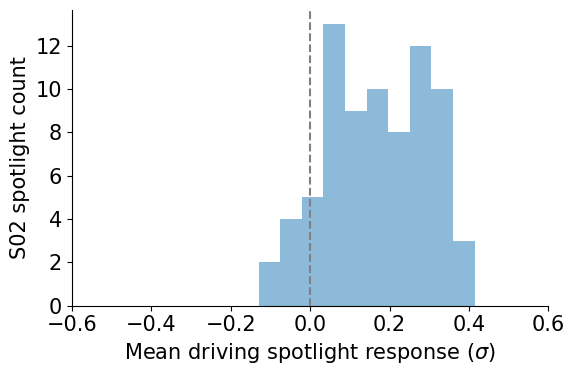

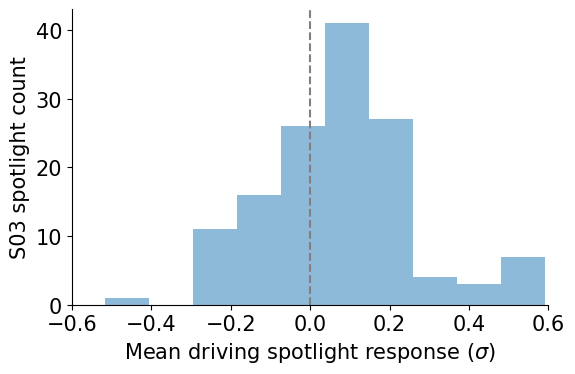

In [21]:
# subject = 'S02'
# subject = 'S03'
for subject in ['S02', 'S03']:
    if subject == 'S03':
        gemv_flatmaps_dict = gemv_flatmaps_dict_S03
        gemv_flatmaps_dict_timecourse = gemv_flatmaps_dict_S03_timecourse
    elif subject == 'S02':
        gemv_flatmaps_dict = gemv_flatmaps_dict_S02
        gemv_flatmaps_dict_timecourse = gemv_flatmaps_dict_S02_timecourse

    spotlights_expls = pd.read_csv(
        f'../0_voxel_select/communication_explanations_{subject}_spotlights.csv')
    spotlights_expls = spotlights_expls[~pd.isna(spotlights_expls['explanation'])].rename(
        columns={'Unnamed: 0': 'spotlight_idx'}
    ).drop(columns='top_ngrams')
    spotlights_expls['spotlight_idx'] = spotlights_expls['spotlight_idx'].str.replace(
        '_only', '').astype(int)

    SPOTLIGHT_DICT = {
        'name': [
            'Clothing and Physical Appearance', 'Colors', 'Dialogue',
            'Gruesome body imagery', 'Introspection', 'Measurements',
            'Numbers', 'Relationships', 'Times', 'Years', 'Fear and Avoidance',
            'Negative Emotional Reactions', 'Positive Emotional Reactions',
            'Professions and Personal Backgrounds', 'Recognition', 'Secretive Or Covert Actions',
            'Sexual and Romantic Interactions'],
        'keywords': [
            ['Cloth'], ['Color'], ['Dialogue', 'Conversation'],
            ['Gruesome'], ['Introspection', 'Reflection'], ['Measurement'],
            ['Numbers'], ['Relationships'], ['Time'], [
                'Years'], ['Fear', 'Avoidance'],
            ['Negative Emotional', 'negativity'], [
                'Positive Emotional', 'positivity', 'joy', 'happiness'],
            ['Professions'], ['Recognition'], ['Secretive'],
            ['Sexual', 'Romantic']],
        'explanation': [],
        'spotlight_idx': [],
    }
    for i in range(len(SPOTLIGHT_DICT['name'])):
        keywords = SPOTLIGHT_DICT['keywords'][i]
        for keyword in keywords:
            df_match = spotlights_expls[spotlights_expls['explanation'].str.contains(
                keyword, case=False)]
        SPOTLIGHT_DICT['explanation'].append(df_match['explanation'].values)
        SPOTLIGHT_DICT['spotlight_idx'].append(
            df_match['spotlight_idx'].values)
    df = pd.DataFrame(SPOTLIGHT_DICT)

    def zscore_to_pvalue_right_tailed(z):
        """Return the right-tailed p-value for a given z-score."""
        return 1 - norm.cdf(z)

    rois_dict_spotlights = load_custom_rois(
        subject, suffix_setting='_spotlights')
    driving_scores = []
    # flatmaps = []
    zscores = []
    pvals = []
    for i in range(len(df)):
        row = df.iloc[i]
        driving_score = []
        flatmap = gemv_flatmaps_dict[(row['name'], None)]
        for spotlight_idx in row['spotlight_idx']:
            spotlight_mask = rois_dict_spotlights[f'spot{spotlight_idx}'] > 0
            driving_score.append(np.mean(flatmap[spotlight_mask]))
            timecourse_roi = gemv_flatmaps_dict_timecourse[(
                row['name'], None)][spotlight_mask]
            stderr = timecourse_roi.mean(
                axis=0).std() / np.sqrt(timecourse_roi.shape[1])
            # .mean(axis=0).std()
            # print(timecourse.shape)
        driving_scores.append(driving_score)
        zscore = driving_score / stderr
        zscores.append(zscore)
        pvals.append(zscore_to_pvalue_right_tailed(zscore))
        # flatmaps.append(flatmap)
    df['driving_score'] = driving_scores
    df['zscore'] = zscores
    df['pval'] = pvals
    # df['flatmap'] = flatmaps

    d = {
        k: np.concatenate(df[k])
        for k in ['explanation', 'spotlight_idx', 'driving_score', 'zscore', 'pval']
    }
    df_spotlights = pd.DataFrame(d)
    d_rep = df.explode('spotlight_idx')
    d_rep = d_rep[~d_rep['spotlight_idx'].isna()]
    for k in ['name']:  # , 'flatmap']:
        df_spotlights[k] = d_rep[k].values

    # all_driving_scores = np.concatenate(df['driving_score'].values).flatten()
    plot_val = 'driving_score'
    # plot_val = 'pval'
    plt.figure(figsize=(6, 4))
    plt.hist(df_spotlights[plot_val], alpha=0.5)
    plt.xlim(-0.6, 0.6)
    # avg = np.mean(df_spotlights[plot_val])
    # plt.axvline(avg, color='black')
    # annotate with mean
    # plt.text(avg + 0.01, 10, f'mean={avg:.2f}', color='black')
    # median = np.median(df_spotlights[plot_val])
    # plt.axvline(median, color='red')
    plt.axvline(0, color='gray', linestyle='--')
    # annotate with median
    # plt.text(median + 0.01, 10, f'median={median:.2f}', color='red')
    # plt.xlabel(f'GEM-V {plot_val} ($\sigma$)')
    plt.xlabel('Mean driving spotlight response ($\sigma$)')
    plt.ylabel(f'{subject} spotlight count')
    # plt.title(subject)
    plt.tight_layout()
    plt.savefig(f'spotlights_driving_scores_{subject}.pdf')
    plt.show()
    # plt.axvline(np.mean(all_driving_scores), color='red')
    df_spotlights.to_pickle(f'spotlights_driving_scores_{subject}.pkl')

In [ ]:
df_spotlights_S02 = pd.read_pickle('spotlights_driving_scores_S02.pkl')
df_spotlights_S03 = pd.read_pickle('spotlights_driving_scores_S03.pkl')
names_intersection_hypotheses = set(
    df_spotlights_S02['name']).intersection(set(df_spotlights_S03['name']))
df_spotlights_S02 = df_spotlights_S02[df_spotlights_S02['name'].isin(
    names_intersection_hypotheses)]
df_spotlights_S03 = df_spotlights_S03[df_spotlights_S03['name'].isin(
    names_intersection_hypotheses)]

alpha = 0.05
df_spotlights_S02['pval_corrected'] = multipletests(
    df_spotlights_S02['pval'], alpha=alpha, method='fdr_bh')[1]
df_spotlights_S03['pval_corrected'] = multipletests(
    df_spotlights_S03['pval'], alpha=alpha, method='fdr_bh')[1]
df_spotlights_S02.to_pickle('spotlights_driving_scores_S02.pkl')
df_spotlights_S03.to_pickle('spotlights_driving_scores_S03.pkl')
print('num_hypotheses_S02:',
      df_spotlights_S02.shape[0], 'num_hypotheses_S03:', df_spotlights_S03.shape[0])
print('num_significant_S02:', np.sum(df_spotlights_S02['pval_corrected'] < alpha), 'num_significant_S03:', np.sum(
    df_spotlights_S03['pval_corrected'] < alpha))
for subject in ['S02', 'S03']:
    rois_dict_spotlights = load_custom_rois(
        subject, suffix_setting='_spotlights')
    print('num_spotlights', subject, len(rois_dict_spotlights))

num_hypotheses_S02: 73 num_hypotheses_S03: 128
num_significant_S02: 47 num_significant_S03: 21
num_spotlights S02 582
num_spotlights S03 535


In [ ]:
df_spotlights_S02 = pd.read_pickle('spotlights_driving_scores_S02.pkl')
df_spotlights_S03 = pd.read_pickle('spotlights_driving_scores_S03.pkl')
rois_dict_spotlights_S02 = load_custom_rois(
    'S02', suffix_setting='_spotlights')
rois_dict_spotlights_S03 = load_custom_rois(
    'S03', suffix_setting='_spotlights')

# threshold by driving_score
# thresh = 0.05
# df_spotlights_S02 = df_spotlights_S02[df_spotlights_S02['driving_score'] > thresh]
# df_spotlights_S03 = df_spotlights_S03[df_spotlights_S03['driving_score'] > thresh]
alpha = 0.05
df_spotlights_S02 = df_spotlights_S02[df_spotlights_S02['pval_corrected'] < alpha]
df_spotlights_S03 = df_spotlights_S03[df_spotlights_S03['pval_corrected'] < alpha]

# visualize
names_unique = set(df_spotlights_S02['name'].unique()).intersection(
    df_spotlights_S03['name'].unique())
names_unique = list(names_unique)
print('num sig S02', len(df_spotlights_S02),
      'num sig S03', len(df_spotlights_S03), 'num expls with sig region for both subjects', len(names_unique))

In [ ]:
for name in tqdm(names_unique):
    spotlights_idx_S02 = df_spotlights_S02[df_spotlights_S02['name']
                                           == name]['spotlight_idx'].values.tolist()
    spotlights = [
        rois_dict_spotlights_S02[f'spot{spotlight_idx}'] for spotlight_idx in spotlights_idx_S02]
    spotlight_sum_S02 = np.sum(spotlights, axis=0)

    # scores
    flatmap = gemv_flatmaps_dict_S02[(name, None)]
    spotlights_scores_S02 = np.zeros_like(spotlight_sum_S02)
    spotlights_scores_S02[spotlight_sum_S02 >
                          0] = flatmap[spotlight_sum_S02 > 0]

    spotlights_idx_S03 = df_spotlights_S03[df_spotlights_S03['name']
                                           == name]['spotlight_idx'].values.tolist()
    spotlights = [rois_dict_spotlights_S03[f'spot{spotlight_idx}']
                  for spotlight_idx in spotlights_idx_S03]
    spotlight_sum_S03 = np.sum(spotlights, axis=0)

    # scores
    flatmap = gemv_flatmaps_dict_S03[(name, None)]
    spotlights_scores_S03 = np.zeros_like(spotlight_sum_S03)
    spotlights_scores_S03[spotlight_sum_S03 >
                          0] = flatmap[spotlight_sum_S03 > 0]

    # print(name, 'S02', 'max', np.max(spotlights_scores_S02),
    #       'min', np.min(spotlights_scores_S02))
    # print(name, 'S03', 'max', np.max(spotlights_scores_S03),
    #         'min', np.min(spotlights_scores_S03))

    sasc.viz._save_flatmap(
        spotlights_scores_S02, 'S02', fname_save=f'rois_spotlights/{name}_scores_S02.png', vabs=0.6, clab='Difference from baseline ($\sigma$)')
    sasc.viz._save_flatmap(
        spotlights_scores_S03, 'S03', fname_save=f'rois_spotlights/{name}_scores_S03.png', vabs=0.6, clab='Difference from baseline ($\sigma$)')

In [ ]:
for suff in ['_scores']:
    # read all plots and save as subplots on the same page
    for subject in ['S02', 'S03']:
        n = len(names_unique)
        C = 5
        R = int(ceil(n/C))
        fig, axs = plt.subplots(R, C, figsize=(C * 3, R * 2))
        axs = axs.ravel()
        for i in range(n):
            name = names_unique[i]
            axs[i].imshow(Image.open(
                f'rois_spotlights/{name}{suff}_{subject}.png'))
            axs[i].axis('off')
            if subject == 'S02':
                axs[i].set_title(
                    f'{name.replace("Times", "Time")}', fontsize='xx-small')

        plt.tight_layout()
        plt.savefig(f'rois_spotlights/all_{subject}{suff}.pdf', dpi=300)